In [1]:
import pandas as pd
import plotly.express as px
from src.pipelines.data_quality import insight_dirty_cost
from src.config.database_models import engine
import plotly.io as pio
df_dirty, df_clean = insight_dirty_cost()
pio.renderers.default = "png"

# 1. Custo da Sujeira:

In [2]:
df1 = df_clean.groupby('id_store').agg({
    'id_order': ['count'],
    'price': ['sum']
})
df1 = df1.reset_index()
df1.columns = ['id_store', 'count_orders', 'sum_orders']
df1.sort_values(['sum_orders', 'count_orders'], ascending=False)

,id_store,count_orders,sum_orders
8,LJ-09,420,159809.03
6,LJ-07,433,156908.79
2,LJ-03,411,154381.59
9,LJ-10,401,154293.39
3,LJ-04,403,150381.52
0,LJ-01,393,148146.81
7,LJ-08,409,147956.84
1,LJ-02,406,146578.48
5,LJ-06,406,143080.62
4,LJ-05,373,130648.08


- Faturamento Limpo

In [3]:
df2 = df_dirty.groupby('loja_id').agg({
    'id_venda': ['count'],
    'valor': ['sum']
})

df2 = df2.reset_index()
df2.columns = ['id_store_dirty', 'count_orders_dirty', 'sum_orders_dirty']
df2.sort_values('sum_orders_dirty', ascending=False)

,id_store_dirty,count_orders_dirty,sum_orders_dirty
8,LJ-09,468,176925.66
6,LJ-07,477,176161.23
2,LJ-03,471,175553.97
9,LJ-10,447,172019.75
0,LJ-01,448,169830.84
3,LJ-04,453,168096.71
7,LJ-08,456,165283.25
1,LJ-02,450,163665.91
5,LJ-06,452,158333.72
4,LJ-05,423,147915.43


- Faturamento 'Sujo'

In [4]:
df_merge = pd.merge(df2, df1, left_on='id_store_dirty', right_on='id_store', how='left')
df_merge

,id_store_dirty,count_orders_dirty,sum_orders_dirty,id_store,count_orders,sum_orders
0,LJ-01,448,169830.84,LJ-01,393,148146.81
1,LJ-02,450,163665.91,LJ-02,406,146578.48
2,LJ-03,471,175553.97,LJ-03,411,154381.59
3,LJ-04,453,168096.71,LJ-04,403,150381.52
4,LJ-05,423,147915.43,LJ-05,373,130648.08
5,LJ-06,452,158333.72,LJ-06,406,143080.62
6,LJ-07,477,176161.23,LJ-07,433,156908.79
7,LJ-08,456,165283.25,LJ-08,409,147956.84
8,LJ-09,468,176925.66,LJ-09,420,159809.03
9,LJ-10,447,172019.75,LJ-10,401,154293.39


- Merge para trabalhar com somente um dataframe.

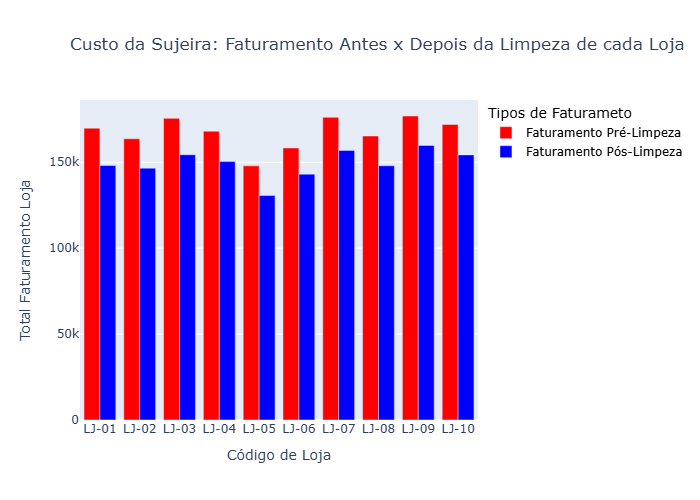

In [5]:
fig = px.bar(df_merge, 
             x='id_store_dirty', 
             y=['sum_orders_dirty', 'sum_orders'],
             labels={'id_store_dirty': 'Código de Loja', 'value': 'Total Faturamento Loja'},
             title='Custo da Sujeira: Faturamento Antes x Depois da Limpeza de cada Loja',
             barmode='group',
             color_discrete_map={'sum_orders_dirty': 'red', 'sum_orders': 'blue'})

fig.update_traces(selector={'name': 'sum_orders_dirty'}, name='Faturamento Pré-Limpeza')
fig.update_traces(selector={'name': 'sum_orders'}, name='Faturamento Pós-Limpeza')
fig.update_layout(legend=dict(title='Tipos de Faturameto', font=dict(size=12, color='black')), title_x=0.1)       
fig.show()

Neste gráfico podemos perceber que a limpeza dos dados causou uma grande perda no faturamento de cada loja. Neste caso em específico, este declínio se deu por falta de informações de registro necessárias (falta de informações sobre id_loja). Sendo necessário uma revisão do meio em que é registrada as vendas, assim impedindo esse tipo de erro.

# 2. Ranking de Filiais

In [6]:
df_ranking_stores = df_clean.groupby(by='id_store').agg({
        'price': ['sum'],
        'id_order': ['count']
})

df_ranking_stores = df_ranking_stores.reset_index()
df_ranking_stores.columns = ['código_loja', 'faturamento_anual', 'qtd_vendas']
df_ranking_stores['faturamento_anual'] = df_ranking_stores['faturamento_anual'].apply(lambda x: f'R$ {x:,.2f}'
                                                                                      .replace('.', '#')
                                                                                      .replace(',', '.')
                                                                                      .replace('#', ','))
df_ranking_stores.sort_values(['faturamento_anual'],ascending=False)

,código_loja,faturamento_anual,qtd_vendas
8,LJ-09,"R$ 159.809,03",420
6,LJ-07,"R$ 156.908,79",433
2,LJ-03,"R$ 154.381,59",411
9,LJ-10,"R$ 154.293,39",401
3,LJ-04,"R$ 150.381,52",403
0,LJ-01,"R$ 148.146,81",393
7,LJ-08,"R$ 147.956,84",409
1,LJ-02,"R$ 146.578,48",406
5,LJ-06,"R$ 143.080,62",406
4,LJ-05,"R$ 130.648,08",373


Como podemos observar diante o dataframe gerado, a loja que mais gerou receita anual foi a **LJ-09** com um total de _R$ 159.809,03_, tendo registrados _420_ vendas. Por outro lado, a loja com menor desempenho foi a loja **LJ-05** com um total de _R$ 130.648,08_, registrando 'somente' _373_ vendas. Uma diferença de _R$ 29.160,95_. Sendo assim, tendo que rever meios de venda e promoção dos itens para tentar alavancar as vendas.

# 3. Faturamento das Categorias

In [7]:
df_products = pd.read_sql('products_dim', engine)

df_clean_products = df_clean[['id_order', 'price', 'id_product']]
df_merge_products = pd.merge(df_clean_products, df_products, on='id_product', how='left')
df_merge_products

,id_order,price_x,id_product,category,price_y
0,42953,29.76,PROD-001,Eletrônicos,29.76
1,99353,325.53,PROD-049,Brinquedos,325.53
2,44522,325.53,PROD-049,Brinquedos,325.53
3,76542,731.38,PROD-041,Móveis,731.38
4,93748,645.99,PROD-039,Eletrônicos,645.99
...,...,...,...,...,...
4050,84098,35.11,PROD-005,Decoração,35.11
4051,87526,221.52,PROD-040,Decoração,221.52
4052,69942,348.46,PROD-048,Brinquedos,348.46
4053,98805,475.52,PROD-010,Decoração,475.52


In [8]:
df_merge_products = df_merge_products.groupby(by='category').agg({
            'price_x': ['sum'],
            'id_order': ['count']
})
df_merge_products = df_merge_products.reset_index()
df_merge_products.columns = ['nome_categoria', 'faturamento_categoria', 'qtd_vendas']
df_merge_products.sort_values('faturamento_categoria', ascending=False)

,nome_categoria,faturamento_categoria,qtd_vendas
0,Brinquedos,316479.66,900
6,Móveis,295180.17,563
8,Roupas,221483.90,710
2,Decoração,166588.66,754
5,Eletrônicos,124562.49,386
9,eletronicos,85345.70,171
4,Eletro,60150.62,184
1,Confecção,49227.02,74
3,ELETRONICOS,48092.18,82
10,moveis,47344.80,80


Aqui já ordenado, podemos analisar as categorias que mais geraram receita aos cofres da empresa e, também, as que menos geraram. Com destaque à categoria de _Brinquedos_, tendo se consolidado como a que mais realizou vendas, _900_, e gerou receita, _R$ 316.479,66_. Também possível ver uma baixa em categorias abaixo dos R$ 50.000,00 de receita, com uma disparidade na quantidade de vendas.

In [9]:
df_top1 = df_merge_products.nlargest(1, 'faturamento_categoria')
faturamento_brinquedos = sum(df_top1['faturamento_categoria'])

faturamento_restante = sum(df_merge_products['faturamento_categoria'])

Separo o faturamento da categoria top 1 (Brinquedos), e o faturamento de todas as categorias. 

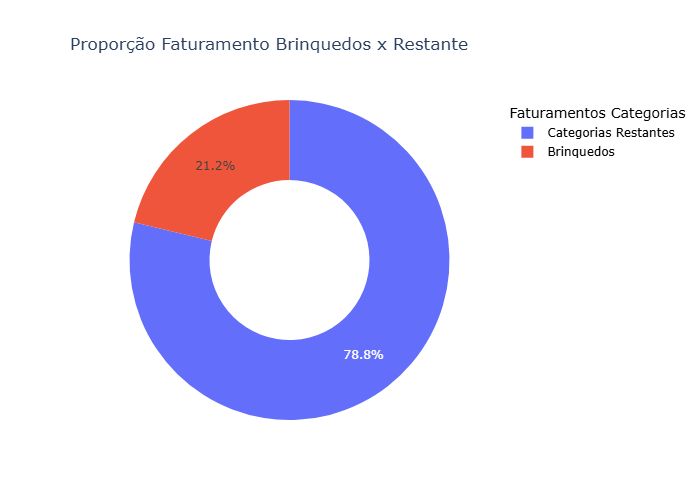

In [10]:
fig = px.pie(data_frame=pd.DataFrame([faturamento_brinquedos, faturamento_restante - faturamento_brinquedos], columns=['Faturamento']),
             names=['Brinquedos', 'Categorias Restantes'],
             values='Faturamento',
             title='Proporção Faturamento Brinquedos x Restante',
             hole=0.5)
fig.update_layout(legend=dict(title='Faturamentos Categorias', font=dict(size=12, color='black')), title_x=0.1) 
fig.show()

Neste gráfico, mostra que a categoria Brinquedos representa um total de **_21,2%_** do faturamento anual total.
Previamente também foi aplicada à Regra de Pareto (80/20), onde apresentou resultados de **_40,9%_**